## Necessary Imports

In [41]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import copy as cp
import random
from sklearn import tree
from numpy import mean
import xgboost 
from xgboost import plot_importance
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score,classification_report
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from numpy import percentile

## Load Data

In [71]:
data=pd.read_csv('C:/Users/User 1/Downloads/recruiting_zeta-disease_training-data_take-home-challenge.csv')
data = data.dropna()

## Column Names

In [61]:
data.columns

Index(['age', 'weight', 'bmi', 'blood_pressure', 'insulin_test',
       'liver_stress_test', 'cardio_stress_test', 'years_smoking',
       'zeta_disease'],
      dtype='object')

## Count Instances of Predicted Classes

In [62]:
data['zeta_disease'].value_counts()

0    521
1    279
Name: zeta_disease, dtype: int64

## Change Zeros in Columns to the Column Means

In [63]:
names=['bmi','blood_pressure','insulin_test','cardio_stress_test']

for i in names:
    data[i]=data[i].replace(0,data[i].mean())

In [64]:
data

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80.0,85.8875,1.5038,43.12125,10,0
1,23,150,38.5,68.0,71.0000,0.3868,55.00000,2,0
2,47,186,29.9,90.0,85.8875,0.2728,43.12125,7,0
3,18,150,30.8,70.0,1033.0000,0.6598,56.00000,0,0
4,24,160,32.4,74.0,125.0000,0.7608,59.00000,2,0
...,...,...,...,...,...,...,...,...,...
795,26,161,28.4,90.0,78.0000,0.5578,42.00000,3,0
796,37,165,33.7,60.0,85.8875,0.3078,69.00000,6,1
797,27,166,25.6,74.0,85.8875,0.2638,43.12125,5,0
798,109,139,28.1,66.0,94.0000,0.2298,53.00000,1,0


## Five Number Summary Each Column

In [66]:
##remove outliers for all columns after testing once with the algorithm
for i in data.columns[:-1]:
    quartiles = [percentile(data[i],25),percentile(data[i],50),percentile(data[i],75)]
    # calculate min/max
    data_min, data_max = data[i].min(), data[i].max()
    # print 5-number summary
    print('Column *****************************************************', i)
    print('Min: %.3f' % data_min)
    print('Q1: %.3f' % quartiles[0])
    print('Median: %.3f' % quartiles[1])
    print('Q3: %.3f' % quartiles[2])
    print('Max: %.3f' % data_max)

Column ***************************************************** age
Min: 18.000
Q1: 21.000
Median: 26.000
Q3: 38.000
Max: 109.000
Column ***************************************************** weight
Min: 94.000
Q1: 149.000
Median: 167.000
Q3: 192.000
Max: 308.000
Column ***************************************************** bmi
Min: 18.200
Q1: 27.500
Median: 32.202
Q3: 36.525
Max: 86.100
Column ***************************************************** blood_pressure
Min: 24.000
Q1: 64.000
Median: 72.000
Q3: 80.000
Max: 157.000
Column ***************************************************** insulin_test
Min: 14.000
Q1: 85.888
Median: 85.888
Q3: 130.000
Max: 1077.000
Column ***************************************************** liver_stress_test
Min: 0.141
Q1: 0.308
Median: 0.445
Q3: 0.700
Max: 3.481
Column ***************************************************** cardio_stress_test
Min: 37.000
Q1: 43.121
Median: 53.000
Q3: 62.000
Max: 214.000
Column ***************************************************** 

## Correlation Matrix for Visualization of Features

<AxesSubplot:>

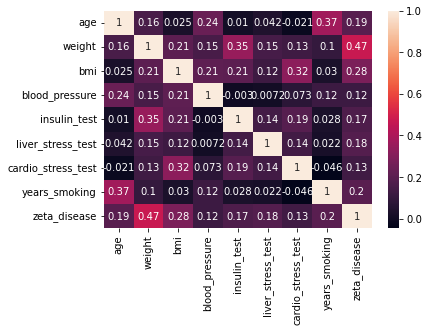

In [69]:
##Correlation before outliers were removed
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)

## Train Test Split

In [50]:
##Maybe outliers are indicative of getting Zeta.  Keep them in and perform the
##classification for each test data.
target=data.pop('zeta_disease')
X_train, X_test, y_train, y_test = train_test_split(data
                                                    , target, test_size=0.3,random_state=2)

## Tuning Hyperparameters of Xgboost Model

In [51]:
xgb_model = XGBClassifier(use_label_encoder=False)

#uniform called from scipy needs to have the reverse 
params = {
    "colsample_bytree": uniform(0.3, 0.7),
    "gamma": uniform(0.001,.5),
    "learning_rate": uniform(.003,1),
    "max_depth": [1,2,3,4,5,6,7], 
    "n_estimators": randint(100, 150), 
    "subsample": uniform(0.001,0.6),
    "min_child_weight":uniform(0,10),
    "max_delta_step":uniform(0,10),
    "reg_alpha":uniform(0,.9),
    "reg_lambda":uniform(1,4),
    "scale_pos_weight":uniform(1,5),
    "tree_method":['auto', 'exact', 'approx', 'hist', 'gpu_hist']
         }

#searching best parameters
search = RandomizedSearchCV(xgb_model, param_distributions=params, 
                            n_iter=200, random_state=42,cv=3, verbose=1, 
                            n_jobs=1, return_train_score=True)

search.fit(X_train, y_train)

#set model with optimal parameters
def tuned_hyper(search_results):
    
    #best params for shorter length later on
    #in case of multiple ones
    whole_array=np.where(search_results['rank_test_score']==1)
    if len(whole_array[0])>1:
        whole_array=np.where(search_results['rank_test_score']==1)[0]
        
    first_spot=int(whole_array[0])
    winning_combo=search_results['params'][first_spot]
    col_tree=winning_combo['colsample_bytree']
    gams=winning_combo['gamma']
    lr=winning_combo['learning_rate']
    m_dep=winning_combo['max_depth']
    nest=winning_combo['n_estimators']
    s_samp=winning_combo['subsample']
    min_ch=winning_combo['min_child_weight']
    max_del=winning_combo['max_delta_step']
    r_alpha=winning_combo['reg_alpha']
    r_lambda=winning_combo['reg_lambda']
    sc_posw=winning_combo['scale_pos_weight']
    treem=winning_combo['tree_method']
    
    #setting the model up with best parameters
    best_model= XGBClassifier(colsample_bytree=col_tree,
                              gamma=gams,
                              learning_rate=lr,
                              max_depth=m_dep,
                              n_estimators=nest, 
                              use_label_encoder=False,
                              subsample=s_samp,
                              min_child_weight=min_ch,
                              max_delta_step=max_del,
                              reg_alpha=r_alpha,
                              reg_lambda=r_lambda,
                              scale_pos_weight=sc_posw,
                              tree_method=treem 
                             )
    return best_model

Fitting 3 folds for each of 200 candidates, totalling 600 fits


C:\Users\User 1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
126 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User 1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User 1\anaconda3\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\Users\User 1\anaconda3\lib\site-packages\xgboost\sklearn.py", line 1400, in fit
    self._Booster = train(
  File "C:\Users\User 1\anaconda3\lib\site-packages\xgboost\core.py", line 

## Fitting Tuned Model to Data

In [72]:
a=tuned_hyper(search.cv_results_)

a.fit(X_train, y_train)

preds=a.predict(X_test)

accuracy_score(y_test,preds)

0.7333333333333333

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

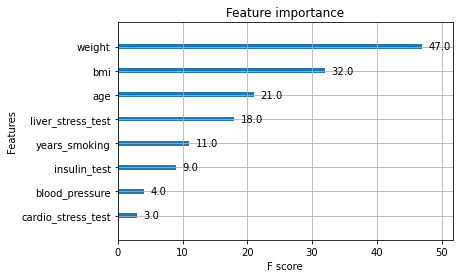

In [54]:
plot_importance(a)

## Confusion Matrix and Metrics

confusion Matrix is :nn [[115  40]
 [ 24  61]]
n
Accuracy  test dataset:  t 0.7333333333333333
ROC-AUC score  test dataset:  t 0.816091081593928
precision score  test dataset:  t 0.6039603960396039
Recall score  test dataset:  t 0.7176470588235294
f1 score  test dataset :  t 0.6559139784946236


Text(0.5, 257.44, 'Predicted label')

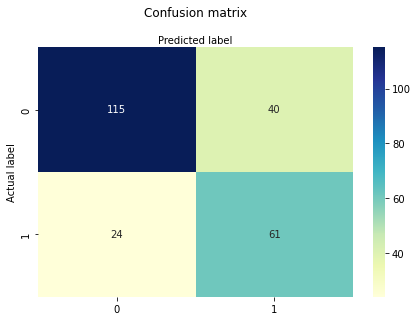

In [55]:

# predict probabilities on Test and take probability for class 1([:1])
y_pred_prob_test = a.predict_proba(X_test)[:, 1]
#predict labels on test dataset
y_pred_test = preds
# create onfusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_test)
print("confusion Matrix is :nn",cm)
print("n")
# Accuracy 
print("Accuracy  test dataset:  t", accuracy_score(y_test,y_pred_test))
# ROC- AUC score
print("ROC-AUC score  test dataset:  t", metrics.roc_auc_score(y_test,y_pred_prob_test))
#Precision score
print("precision score  test dataset:  t", metrics.precision_score(y_test,y_pred_test))#,average='micro'))
#Recall Score
print("Recall score  test dataset:  t", metrics.recall_score(y_test,y_pred_test))
#f1 score
print("f1 score  test dataset :  t", f1_score(y_test,y_pred_test))#,average='binary'))

cm = metrics.confusion_matrix(y_test,preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Classification Table of Results

In [56]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       155
           1       0.60      0.72      0.66        85

    accuracy                           0.73       240
   macro avg       0.72      0.73      0.72       240
weighted avg       0.75      0.73      0.74       240

